In [2]:
library(here)
library(tidyverse)
library(ggrepel)
library(bdkn)
library(data.table)
library(cowplot)


Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%



In [3]:
#################################################################
##### load data
#################################################################

near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", 
               "Jordanian","Druze", "Iranian", "Samaritan")

dt.asc <- readRDS('../data/rds/nea_ascertainment.rds')
dt.asc <- as.data.table(dt.asc)
dt.asc.samples <- dt.asc[sites == 'all' & snp_count > 200000 & !X %in% near_east & pop %in% c('WestEurasia', 'EMH'), unique(X)]

dt.asc.subset <- dt.asc[X %in% dt.asc.samples]
dt.asc.subset.ne <- dt.asc[X %in% dt.asc.samples | X %in% near_east]


basedir2 <- "../data/rds/"
dt.nea_est <- data.table(readRDS(sprintf("%s/%s", basedir2, "nea_estimates.rds")))

dt.nea_est <- 
  dt.nea_est %>%
  filter(!X %in% near_east,
         snp_count > 200000,
         stat == "admixture_prop" | 
           C == "Dinka" & stat == "indirect_f4" |
           C == "Dinka" & stat == "direct_f4" |
           stat == 'qpAdm',
         pop %in% c("EMH", "WestEurasia")) %>% as.data.table

In [4]:
#################################
#### functions
################################

## a function to get the "real" CI by sampling from the standard error for each point
compute_se_ci <- function(dt, my_n = 100, timespan = 45000, just_stats = F, null.m = 0) {
  dt.both_f4.reps = dt[, list(f4 = rnorm(my_n, alpha, stderr), rep = 1:my_n), by=list(X, age)]
  a = dt.both_f4.reps[, list(intercept=lm(f4~age)$coefficients[1],
                             slope=lm(f4~age)$coefficients[2]), by=rep]
  sq <- quantile(a$slope, c(.025,.5,.975))
  # print(sq)
  cat(sprintf('CI of N change over %g years\n', timespan))
  print(-sq*timespan)
  cat(sprintf('CI of slope (f4~age)\n', timespan))
  print(-sq)
  cat(sprintf('P(slope=%f) = %f\n', null.m, (1+sum(a$slope <= null.m)) / a[, .N+1]))
  
  if (just_stats) return(data.table(q025 = -sq[1]*timespan,
                                    q500 = -sq[2]*timespan,
                                    q975 = -sq[3]*timespan,
                                    p_gt0 = (1+sum(a$slope <= null.m)) / a[, .N+1]))
  
  a.ci_full <- a[, list(age = seq(0,50000,10),
                        intercept, slope), rep]
  a.ci_full[, f4 := intercept + slope * age]
  a.ci <- a.ci_full[, list(q_025 = quantile(f4, .025),
                           q_975 = quantile(f4, .975)), age]
}
dt.both_f4.ci <- compute_se_ci(dt.asc.subset[sites == 'all' & stat == 'direct_f4'])



plot_fig1 <- function(dt.nea_f4, my_n = 10000) {
  dt.nea_f4 <- data.table(dt.nea_f4)
  print('Direct f4')
  dt.nea_f4.ci.direct <- compute_se_ci(dt.nea_f4[stat == 'direct_f4'], my_n = my_n)
  print('Indirect f4')
  dt.nea_f4.ci.indirect <- compute_se_ci(dt.nea_f4[stat == 'indirect_f4'], my_n = my_n)
  dt.nea_f4[, f4 := alpha]
  ggplot(mapping=aes(x=age, y=f4)) + 
    scale_x_reverse(limits=c(46000,0)) +
    coord_cartesian(ylim=c(0,.045)) +
    
    geom_ribbon(data=dt.nea_f4.ci.indirect, aes(x=age, ymin=q_025, ymax=q_975, y=NULL, alpha='indirect_f4')) +
    geom_smooth(data=dt.nea_f4[stat=='indirect_f4'], aes(lty=stat), method='lm', se=F, color='black', size=.4) +
    
    geom_ribbon(data=dt.nea_f4.ci.direct, aes(x=age, ymin=q_025, ymax=q_975, y=NULL, alpha='direct_f4')) +
    geom_smooth(data=dt.nea_f4[stat=='direct_f4'], aes(lty=stat), method='lm', se=F, color='black') +
    
    geom_point(data=dt.nea_f4[stat=='indirect_f4'], aes(size=.5), alpha=.5, pch='x', show.legend = F) +
    geom_point(data=dt.nea_f4[stat=='direct_f4'], aes(size=snp_count/1e6), alpha=.5, stroke=0) +
    # geom_point(data=dt.nea_f4.ci, aes(x=age, y=q_025)) +
    geom_errorbar(data=dt.nea_f4[stat=='direct_f4'], aes(ymin=f4-stderr, ymax=f4+stderr), 
                  lty=1, color='black') +
    scale_size_area('SNP Count\n(million)') +
    scale_linetype('Statistic', 
                   labels = c('Direct f4', 'Indirect f4')) +
    scale_alpha_manual('Statistic', values = c(.3,.1), 
                       labels = c('Direct f4', 'Indirect f4')) +
    theme_classic() +
    # theme(panel.grid.major = element_line(size=.1)) + #, color = rgb(1,1,1,1))) +
    # theme(legend.position = c(1,1), legend.justification = c(1.1,1.1)) +
    xlab('Years before present') +
    ylab('Neandertal ancestry proportion') +
    NULL
}


CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0041122225 -0.0006077452 -0.0052381943 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 9.138272e-08 -1.350545e-08 -1.164043e-07 
P(slope=0.000000) = 0.366337


[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0034985330 -0.0008178683 -0.0052317563 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.774518e-08 -1.817485e-08 -1.162613e-07 
P(slope=0.000000) = 0.366263
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02936119 -0.03454202 -0.03977088 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.524708e-07 -7.676005e-07 -8.837972e-07 
P(slope=0.000000) = 0.000100


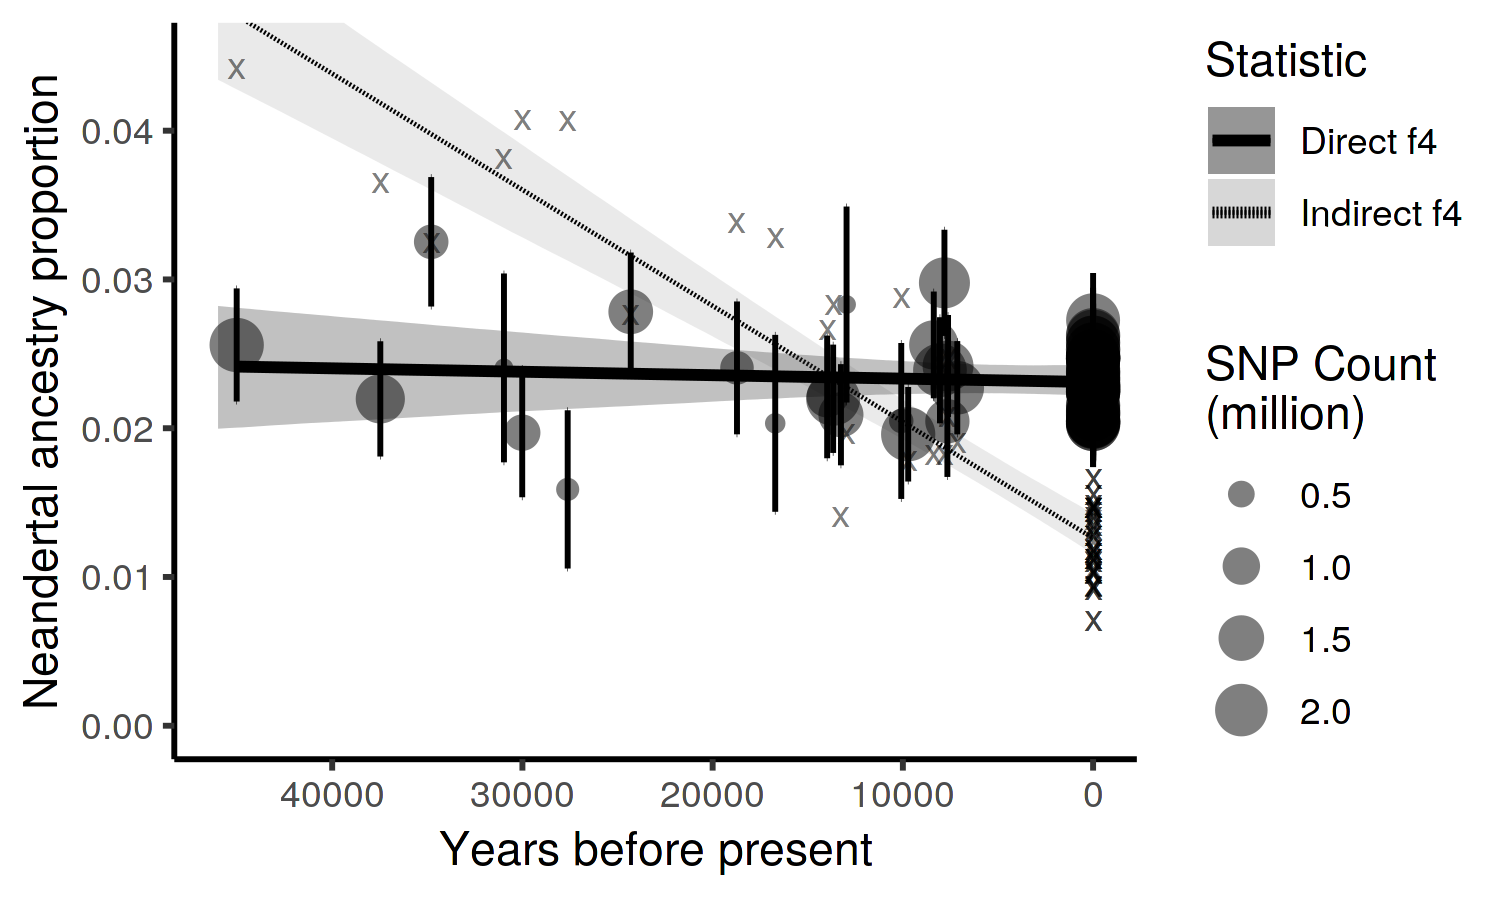

In [6]:
#################################################################
##### figure 01 now w/ indirect points
#################################################################

set_dim(5, 3, 300)

# p1 <- plot_fig1(dt.asc.subset[sites == 'all'], 10000)
p1 <- plot_fig1(dt.nea_est, 10000)
p1

In [11]:
#################################################################
##### code to plot all the ascertainments - for a supplemental fig
#################################################################

ps1.all <- plot_fig1(dt.asc.subset[sites == 'all'], 1000) + 
  ggtitle(sprintf('All sites (%.1fk SNPs)', dt.asc.subset[sites == 'all', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0035594727 -0.0008654158 -0.0052933927 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.909939e-08 -1.923146e-08 -1.176309e-07 
P(slope=0.000000) = 0.348651
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02944472 -0.03464553 -0.03983456 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-6.543272e-07 -7.699008e-07 -8.852125e-07 
P(slope=0.000000) = 0.000999


In [12]:
ps1.ho_afr <- plot_fig1(dt.asc.subset[sites == 'ho_afr'], 1000) + 
  ggtitle(sprintf('HO Afr (%.1fk SNPs)', dt.asc.subset[sites == 'ho_afr', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.002378148 -0.004941055 -0.012700548 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 5.284774e-08 -1.098012e-07 -2.822344e-07 
P(slope=0.000000) = 0.105894
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02491520 -0.02988064 -0.03485104 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.536711e-07 -6.640142e-07 -7.744675e-07 
P(slope=0.000000) = 0.000999


In [13]:
ps1.ho_nonafr <- plot_fig1(dt.asc.subset[sites == 'ho_nonafr'], 1000) + 
  ggtitle(sprintf('HO nonAfr (%.1fk SNPs)', dt.asc.subset[sites == 'ho_nonafr', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
-0.0004172355 -0.0079719699 -0.0151385413 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-9.271899e-09 -1.771549e-07 -3.364120e-07 
P(slope=0.000000) = 0.014985
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03247291 -0.04303083 -0.05357326 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.216203e-07 -9.562407e-07 -1.190517e-06 
P(slope=0.000000) = 0.000999


In [14]:
ps1.bigyri_YRI <- plot_fig1(dt.asc.subset[sites == 'bigyri_YRI'], 1000) + 
  ggtitle(sprintf('YRI hets (%.1fk SNPs)', dt.asc.subset[sites == 'bigyri_YRI', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.010621551  0.002183886 -0.006371527 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 2.360345e-07  4.853080e-08 -1.415895e-07 
P(slope=0.000000) = 0.678322
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03160221 -0.04170348 -0.05176905 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.022714e-07 -9.267439e-07 -1.150423e-06 
P(slope=0.000000) = 0.000999


In [15]:
ps1.bigyri_Altai <- plot_fig1(dt.asc.subset[sites == 'bigyri_Altai'], 1000) + 
  ggtitle(sprintf('Altai hets (%.1fk SNPs)', dt.asc.subset[sites == 'bigyri_Altai', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.002585804 -0.013569497 -0.029509239 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 5.746230e-08 -3.015444e-07 -6.557609e-07 
P(slope=0.000000) = 0.049950
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02574746 -0.07584295 -0.12663490 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.721658e-07 -1.685399e-06 -2.814109e-06 
P(slope=0.000000) = 0.001998


In [16]:
ps1.afr_combined <- plot_fig1(dt.asc.subset[sites == 'afr_combined'], 1000) + 
  ggtitle(sprintf('HO Afr + YRI hets (%.1fk SNPs)', dt.asc.subset[sites == 'afr_combined', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.003248575 -0.003006173 -0.009386512 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.219055e-08 -6.680383e-08 -2.085892e-07 
P(slope=0.000000) = 0.171828
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.02549007 -0.03066934 -0.03584156 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-5.664459e-07 -6.815409e-07 -7.964790e-07 
P(slope=0.000000) = 0.000999


In [17]:
ps1.remainder <- plot_fig1(dt.asc.subset[sites == 'remainder'], 1000) + 
  ggtitle(sprintf('Remainder (%.1fk SNPs)', dt.asc.subset[sites == 'remainder', max(snp_count)/1e3]))

[1] "Direct f4"
CI of N change over 45000 years
         2.5%           50%         97.5% 
 0.0104981816  0.0048711371 -0.0005106768 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 2.332929e-07  1.082475e-07 -1.134837e-08 
P(slope=0.000000) = 0.956044
[1] "Indirect f4"
CI of N change over 45000 years
       2.5%         50%       97.5% 
-0.03150796 -0.04000442 -0.04849729 
CI of slope (f4~age)
         2.5%           50%         97.5% 
-7.001769e-07 -8.889870e-07 -1.077718e-06 
P(slope=0.000000) = 0.000999


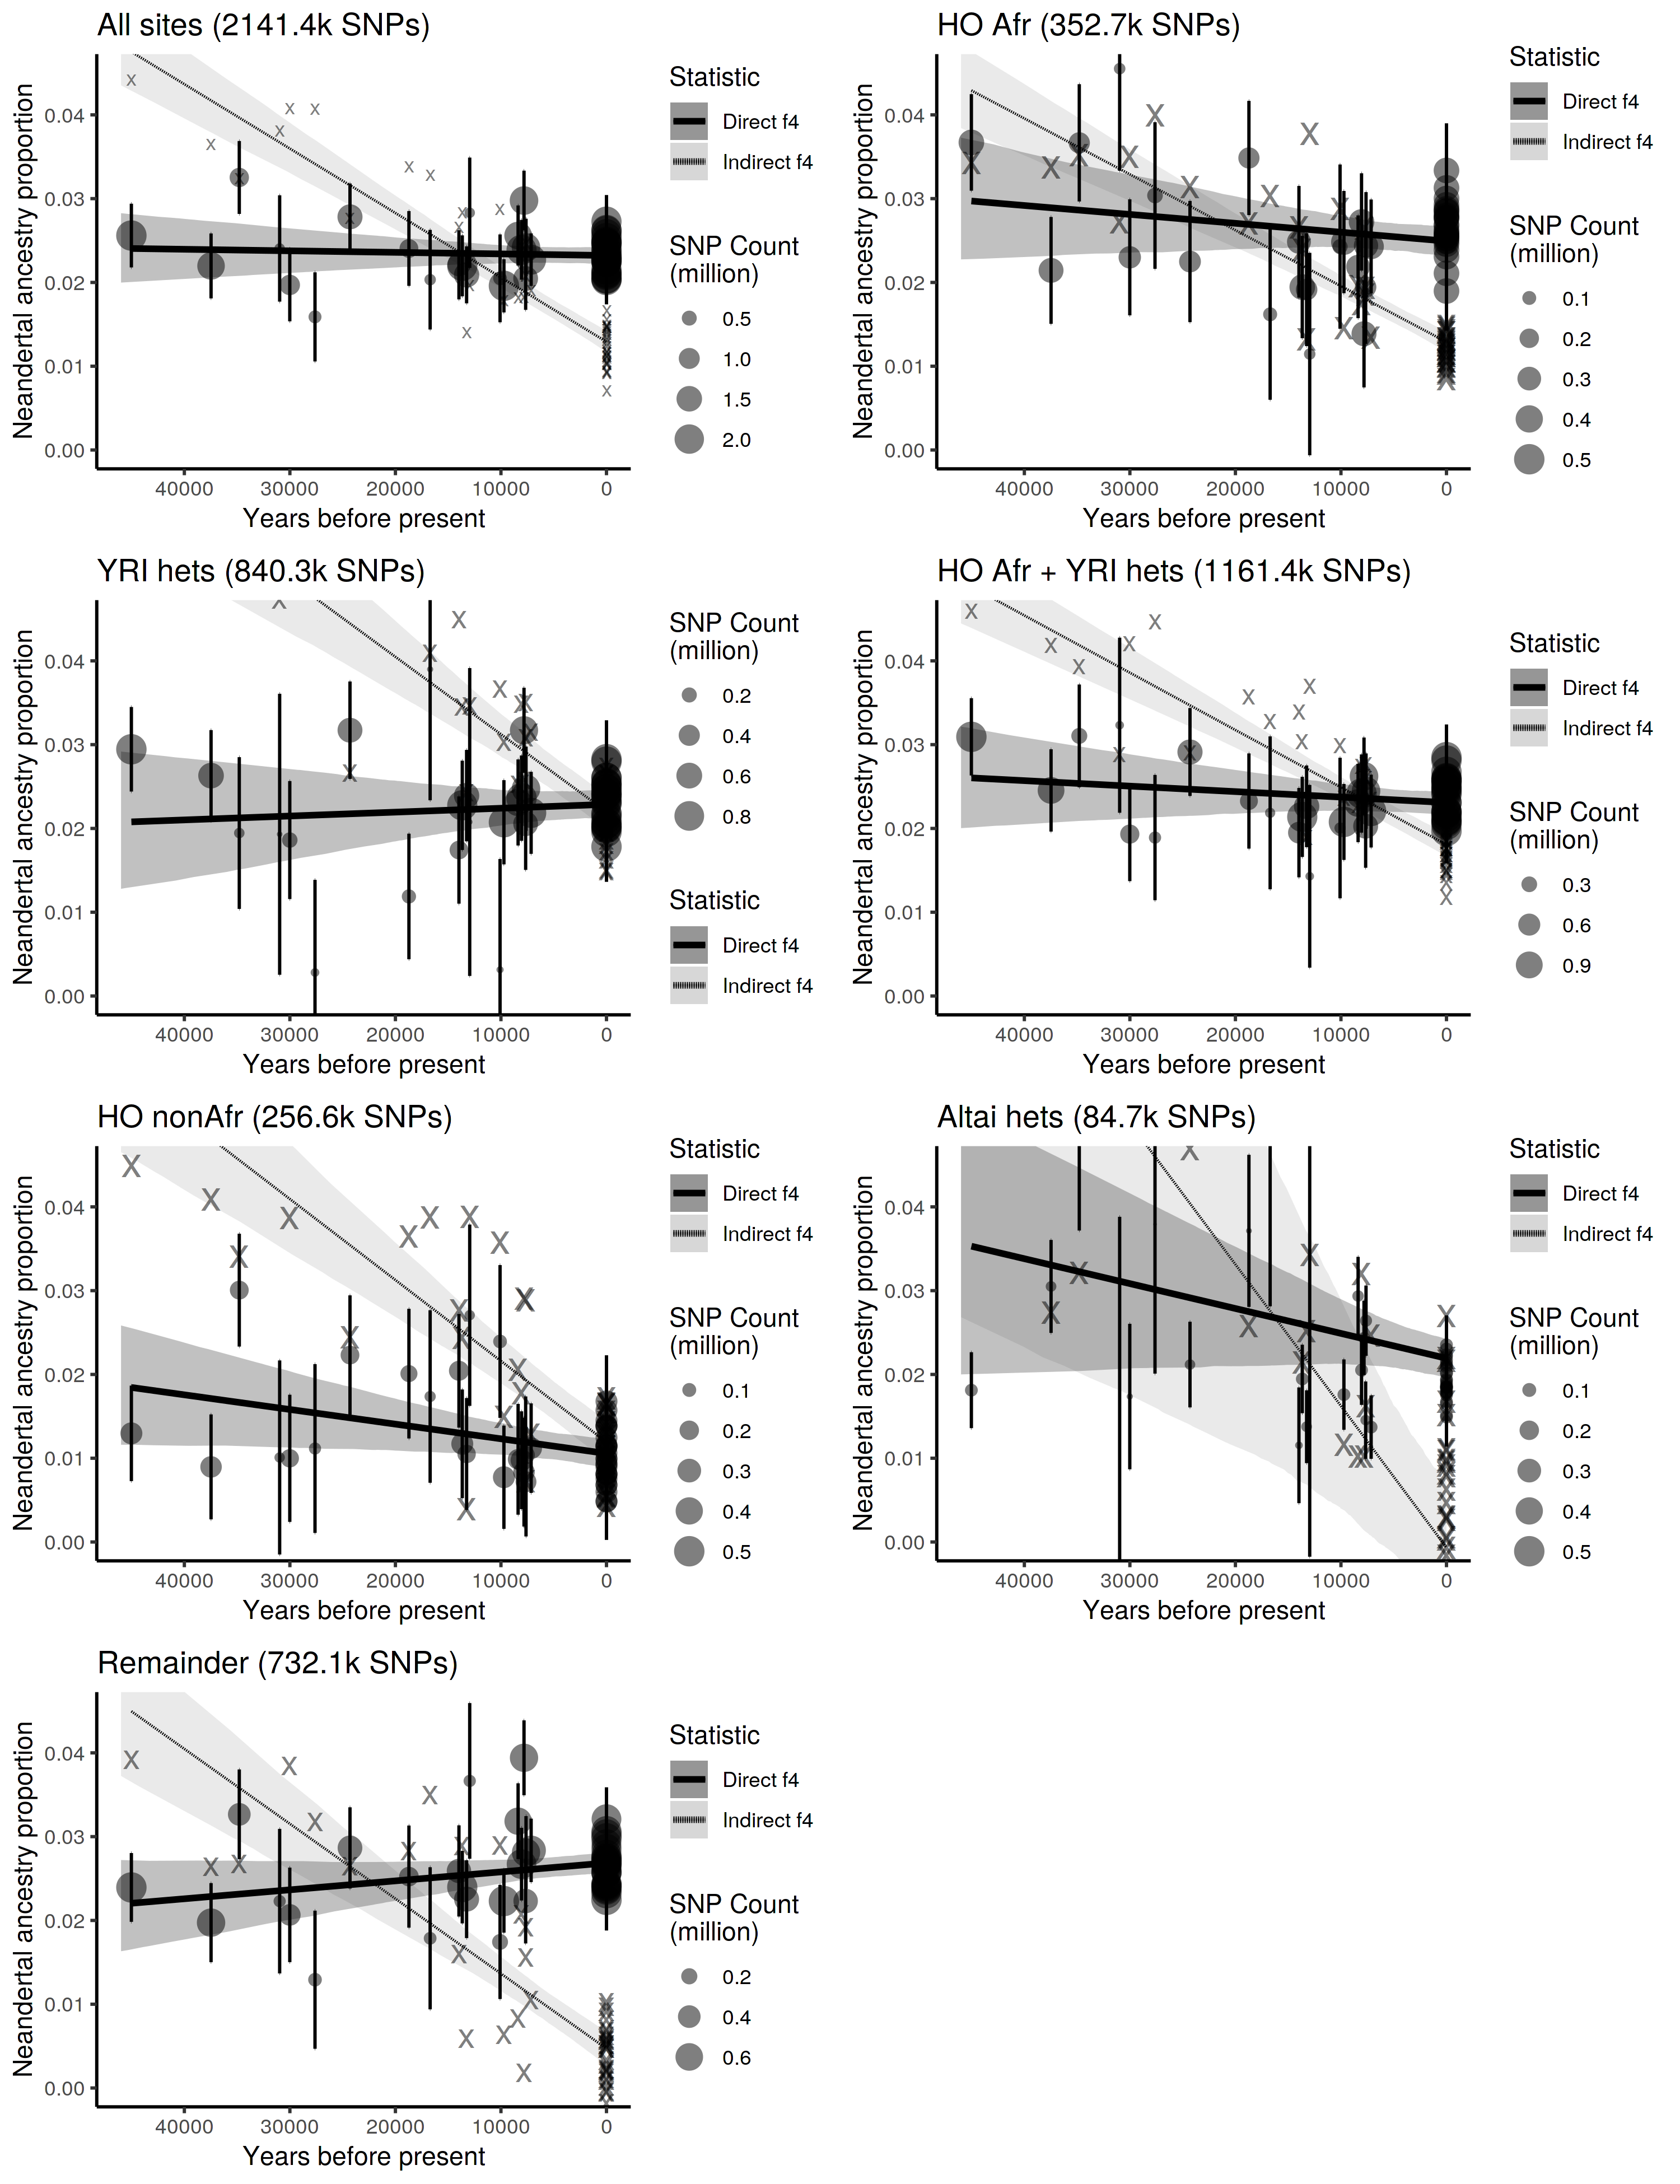

In [18]:
set_dim(10, 13, 300)

plot_grid(ps1.all, ps1.ho_afr, ps1.bigyri_YRI, ps1.afr_combined, 
          ps1.ho_nonafr, ps1.bigyri_Altai, ps1.remainder,
          ncol = 2)

In [19]:

##############################
### qpAdm pvals / slope
##############################

compute_se_ci(dt.nea_est[stat == 'qpAdm' & 
                           sites == 'all' & 
                           snp_count > 200000 & 
                           !X %in% near_east & 
                           pop %in% c('WestEurasia', 'EMH')],
              my_n = 1000, just_stats = T)

CI of N change over 45000 years
        2.5%          50%        97.5% 
 0.003207475 -0.001200068 -0.005501053 
CI of slope (f4~age)
         2.5%           50%         97.5% 
 7.127722e-08 -2.666819e-08 -1.222456e-07 
P(slope=0.000000) = 0.297702


q025,q500,q975,p_gt0
0.003207475,-0.001200068,-0.005501053,0.2977023


In [21]:
##########
## do CI vs Basal Eurasian
##########

compute_se_ci_two_groups <- function(dt, group.1, group.2, my_n = 100, just_stats = F, null.m = 0) {
  
  dt = data.table(dt)
  dt[X %in% group.1, group := 'group1']
  dt[X %in% group.2, group := 'group2']
  
  cat(sprintf('Samples in group: 1:%g, 2:%g, NA:%g\n', 
              dt[group == 'group1', .N],
              dt[group == 'group2', .N],
              dt[is.na(group), .N]))
  
  cat(sprintf('Average N in group: 1: %0.3g, 2: %0.3g, NA: %0.3g\n', 
              dt[group == 'group1', mean(alpha)],
              dt[group == 'group2', mean(alpha)],
              dt[is.na(group), mean(alpha)]))
  
  dt.both_f4.reps = dt[, list(f4 = rnorm(my_n, alpha, stderr), rep = 1:my_n), by=list(X, age, group)]
  
  # get the average N for each resampling and group
  a = dt.both_f4.reps[, list(mean.f4 = mean(f4)), by=.(rep, group)]
  q025 = a[, quantile(mean.f4, .025), by=group]
  q975 = a[, quantile(mean.f4, .975), by=group]
  reps.ratio = 
    a[group == 'group1', mean.f4] / 
    a[group == 'group2', mean.f4]
  
  pval.low = (sum(reps.ratio <= 1) + 1) / a[, .N + 1]
  pval.high = (sum(reps.ratio >= 1) + 1) / a[, .N + 1]
  # print(sq)
  cat(sprintf('CI of N ratio g1/g2: %g-%g\n', 
              quantile(reps.ratio, .025),
              quantile(reps.ratio, .975)))
  cat(sprintf('CI of difference g1/g2: %g-%g\n', 
              quantile(reps.ratio, .025) - 1,
              quantile(reps.ratio, .975) - 1))
  cat(sprintf('p-value N ratio g1/g2 <1: %g; >1: %g\n', 
              pval.low,
              pval.high))

}

In [22]:
compute_se_ci_two_groups(dt.asc.subset[sites == 'all' & stat == 'direct_f4'],
                         dt.asc.subset[sites == 'all' & stat == 'direct_f4' & 
                                         (age == 0 | X %in% c('Kotias', 'Satsurblia', 'Stuttgart', 'Ranchot88')), 
                                       X],
                         dt.asc.subset[sites == 'all' & stat == 'direct_f4' & 
                                         age > 0 & !X %in% c('Kotias', 'Satsurblia', 'Stuttgart', 'Ranchot88'), 
                                       X],
                         my_n = 100000)

Samples in group: 1:31, 2:17, NA:0
Average N in group: 1: 0.023, 2: 0.024, NA: NaN
CI of N ratio g1/g2: 0.8699-1.06198
CI of difference g1/g2: -0.1301-0.0619758
p-value N ratio g1/g2 <1: 0.398403; >1: 0.101604


In [23]:
compute_se_ci_two_groups(dt.asc.subset[sites == 'all' & stat == 'direct_f4'],
                         dt.asc.subset[sites == 'all' & stat == 'direct_f4' & 
                                         (age == 0 | X %in% c('Kotias', 'Satsurblia', 'Stuttgart')), 
                                       X],
                         dt.asc.subset[sites == 'all' & stat == 'direct_f4' & 
                                         age > 0 & !X %in% c('Kotias', 'Satsurblia', 'Stuttgart'), 
                                       X],
                         my_n = 100000)

Samples in group: 1:30, 2:18, NA:0
Average N in group: 1: 0.0231, 2: 0.0238, NA: NaN
CI of N ratio g1/g2: 0.881327-1.07323
CI of difference g1/g2: -0.118673-0.0732274
p-value N ratio g1/g2 <1: 0.364493; >1: 0.135514


In [24]:
compute_se_ci_two_groups(dt.asc.subset.ne[sites == 'all' & stat == 'direct_f4'],
                         dt.asc.subset.ne[sites == 'all' & stat == 'direct_f4' & 
                                            age == 0 & X %in% near_east, X],
                         dt.asc.subset.ne[sites == 'all' & stat == 'direct_f4' & 
                                            age == 0 & !X %in% near_east, X],
                         my_n = 100000)

Samples in group: 1:8, 2:27, NA:21
Average N in group: 1: 0.0203, 2: 0.0233, NA: 0.0234
CI of N ratio g1/g2: 0.7858-0.961578
CI of difference g1/g2: -0.2142--0.0384221
p-value N ratio g1/g2 <1: 0.332346; >1: 0.00099333


In [27]:
#########################################################################
#########################################################################
### grid simulations / figure 2
#########################################################################

dt.sims.full.grid.avg.base2 <- as.data.table(readRDS(here("data/rds/dt.sims.full.grid.avg.base2.rds")))
dt.sims.full.grid.avg.top_mod <- as.data.table(readRDS(here("data/rds/dt.sims.full.grid.avg.top_mod.rds")))

In [31]:
set_dim(6, 4, 300)

cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

top.sim <- dt.sims.full.grid.avg.top_mod[mig1 == 0.1 & mig2 == 0 & m_afr == 0.09 & 
                                           ne_eur == 6000 & ne_afr == 14000 & 
                                           mig_time == 5000]
top.sim.melt = melt(top.sim, id.vars = c('name', 'age'), measure.vars = c('indirect_f4','direct_f4','admix_prop','true_prop'))
# top.labels = c(expression('indirect f'[4]), expression('direct f'[4]), 'adm. prop.', 'true prop.')
top.labels = c('indirect f4', 'direct f4', 'adm. prop.', 'true prop.')
p.top <- ggplot(top.sim.melt, aes(x=age/1000, y=value, color=variable, lty=variable)) +
  geom_smooth(se=F, size=2) +
  scale_x_reverse() +
  xlab('age (ky)') +
  scale_color_manual('', values=cbPalette[c(2,3,4,1)], labels = top.labels) +
  scale_linetype_manual('', values=c('31','31','31','solid'), labels = top.labels)

In [30]:
cc = scales::seq_gradient_pal("white", cbPalette[4], "Lab")(seq(0,1,length.out=15))[2:15]
p1 <- ggplot(dt.sims.full.grid.avg.base2[category == 'mig_e_a'],
             aes(x=age/1000, y=indirect_f4, color=mig1, group=mig1)) +
  geom_smooth(se=F) +
  xlab('age (ky)') +
  scale_color_distiller('E -> A', type = 'seq', palette = 'OrRd', breaks = c(0,.1,.2)) +
  scale_x_reverse()

# p1
p1.psd4.lines <- geom_smooth(data=dt.sims.full.grid.avg.base2[category == 'mig_e_a'], aes(y=direct_f4), lty=3, se=F)
p1.psd4.lines.true <- geom_smooth(data=dt.sims.full.grid.avg.base2[category == 'mig_e_a'], aes(y=true_prop), lty=1, se=F, color='black', size=.5)
# p1 + p1.psd4.lines.true + p1.psd4.lines


cc = scales::seq_gradient_pal("white", cbPalette[6], "Lab")(seq(0,1,length.out=15))[2:15]
p2 <- ggplot(dt.sims.full.grid.avg.base2[category == 'mig_a_e'],
             aes(x=age/1000, y=indirect_f4, color=mig2, group=mig2)) +
  geom_smooth(se=F) + 
  xlab('age (ky)') +
  scale_color_distiller('A -> E', type = 'seq', palette = 'GnBu', breaks = c(0,.1,.2)) +
  scale_x_reverse()
p2.psd4.lines <- geom_smooth(data=dt.sims.full.grid.avg.base2[category == 'mig_a_e'], aes(y=direct_f4), lty=3, se=F)
p2.psd4.lines.true <- geom_smooth(data=dt.sims.full.grid.avg.base2[category == 'mig_a_e'], aes(y=true_prop), lty=1, se=F, color='black', size=.5)
# p2 + p2.psd4.lines.true + p2.psd4.lines


cc = scales::seq_gradient_pal("white", cbPalette[7], "Lab")(seq(0,1,length.out=15))[2:15]
p3 <- ggplot(dt.sims.full.grid.avg.base2[category == 'mig_afr_afr' & m_afr < 0.11],
             aes(x=age/1000, y=indirect_f4, color=m_afr, group=m_afr)) +
  geom_smooth(se=F) + 
  xlab('age (ky)') +
  scale_color_distiller('A <-> A', type = 'seq', palette = 'BuPu', breaks = c(0,.05,.1)) +
  scale_x_reverse()
p3.psd4.lines <- geom_smooth(data=dt.sims.full.grid.avg.base2[category == 'mig_afr_afr' & m_afr < 0.11],
                             aes(y=direct_f4), lty=3, se=F)
p3.psd4.lines.true <- geom_smooth(data=dt.sims.full.grid.avg.base2[category == 'mig_afr_afr'], aes(y=true_prop), lty=1, se=F, color='black', size=.5)
# p3 + p3.psd4.lines.true + p3.psd4.lines

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


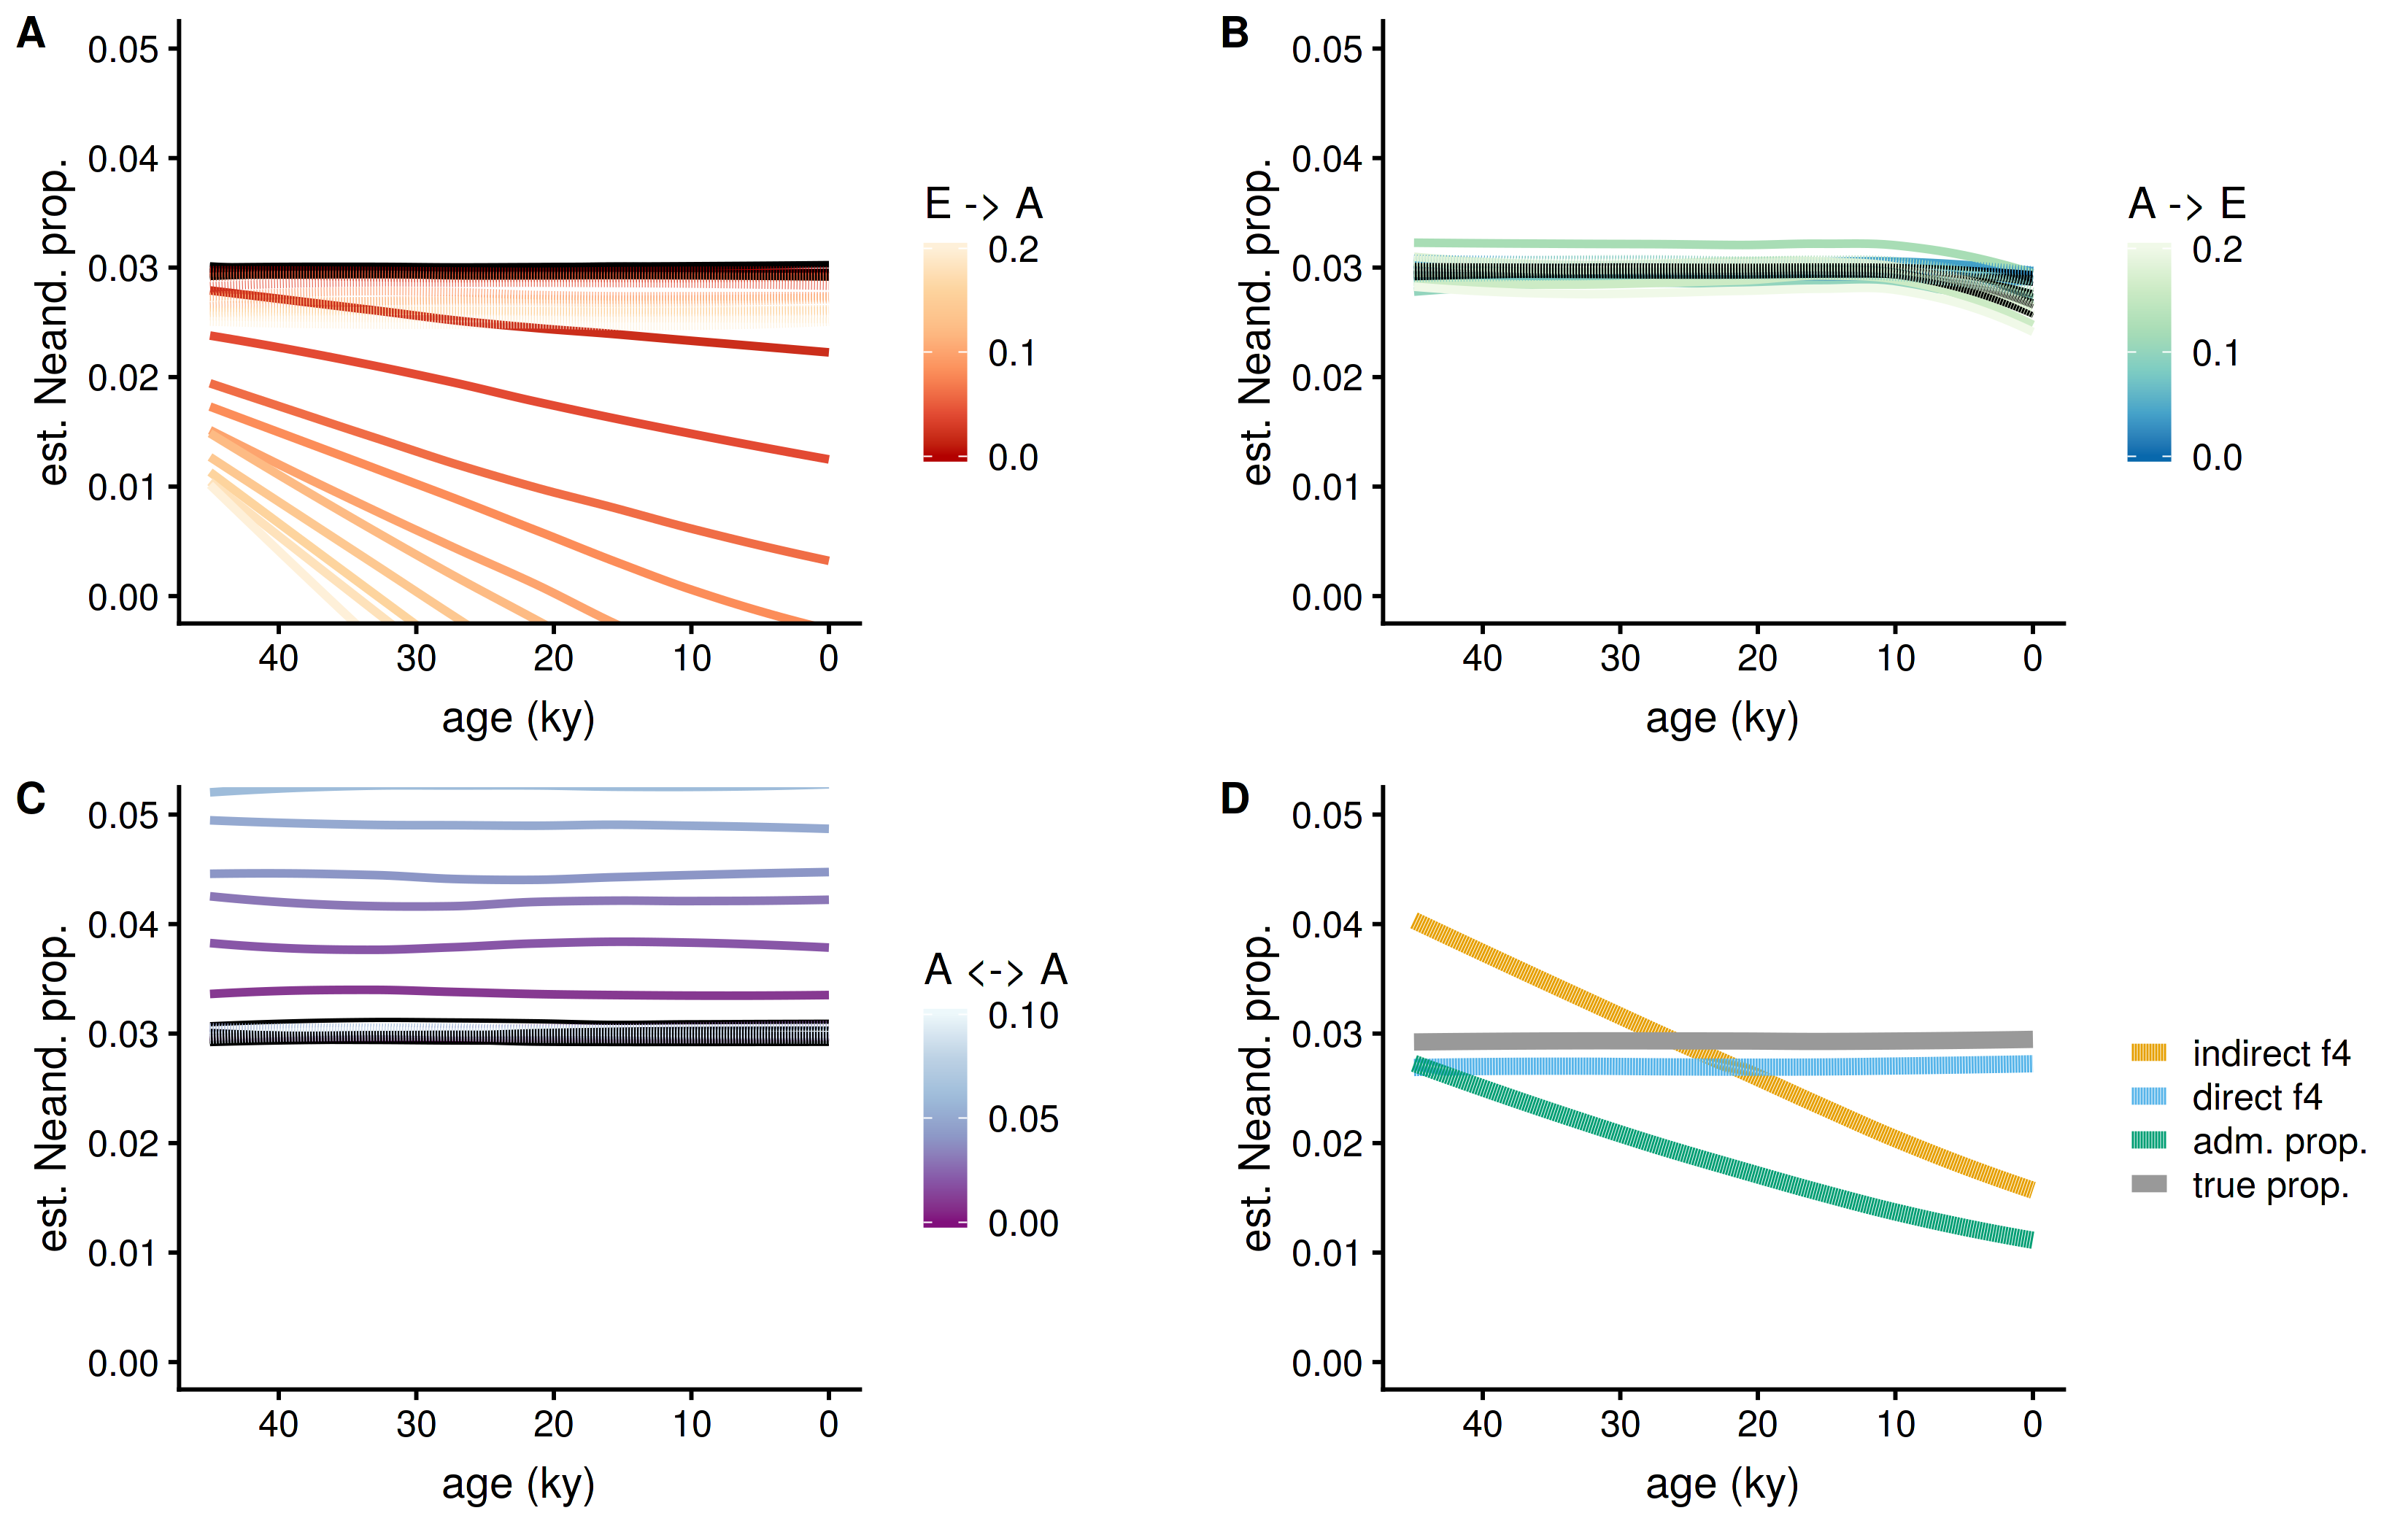

In [34]:
set_dim(11, 7, 300)

p.full <- plot_grid(p1 + p1.psd4.lines.true + p1.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                    p2 + p2.psd4.lines.true + p2.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                    p3 + p3.psd4.lines.true + p3.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                    p.top + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                    align = 'vh', axis='tblr',
                    ncol = 2,
                    labels = 'AUTO')
p.full
#save_plot('~/Google Drive/martin_neand_depletion_over_time/figs_rev_02f.pdf',
#          p.full, base_width = 11, base_height = 7)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


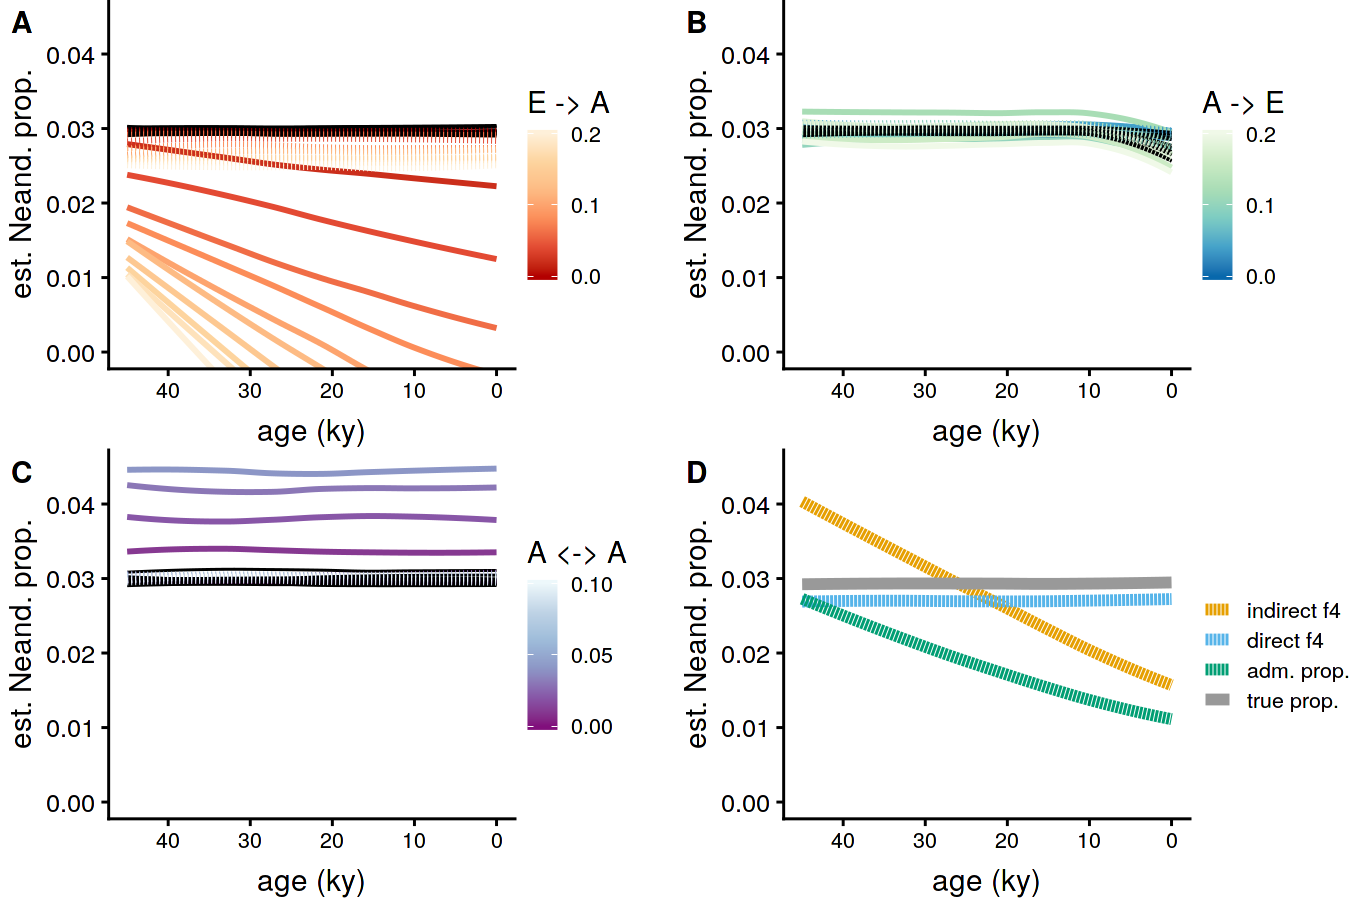

In [35]:
set_dim(9, 6)

p.full <- plot_grid(p1 + p1.psd4.lines.true + p1.psd4.lines + coord_cartesian(ylim=c(0,.045)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=10), legend.text = element_text(size=10), legend.box.margin = margin(l = -15), plot.margin = margin(r=-15)),
                    p2 + p2.psd4.lines.true + p2.psd4.lines + coord_cartesian(ylim=c(0,.045)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=10), legend.text = element_text(size=10), legend.box.margin = margin(l = -15), plot.margin = margin(r=-15)),
                    p3 + p3.psd4.lines.true + p3.psd4.lines + coord_cartesian(ylim=c(0,.045)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=10), legend.text = element_text(size=10), legend.box.margin = margin(l = -15), plot.margin = margin(r=-15)),
                    p.top + coord_cartesian(ylim=c(0,.045)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=10), legend.text = element_text(size=10), legend.box.margin = margin(l = -15), plot.margin = margin(r=-5)),
                    align = 'vh', axis='tblr',
                    ncol = 2,
                    labels = 'AUTO')

p.full

#save_plot('~/Google Drive/martin_neand_depletion_over_time/figs_rev_02f02b.pdf',
#          p.full, base_width = 9, base_height = 6)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


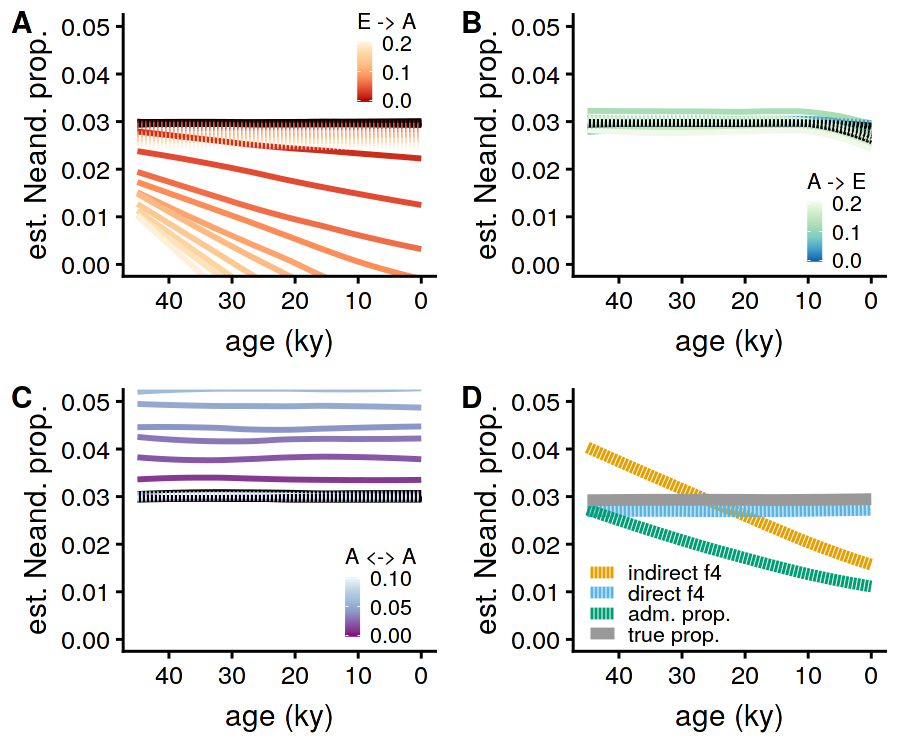

In [36]:
set_dim(6, 5)
p.full <- plot_grid(p1 + p1.psd4.lines.true + p1.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.justification=c(1,0.85), legend.position=c(1,1)) + guides(color = guide_colorbar(barwidth = 0.5, barheight = 2)),
                    p2 + p2.psd4.lines.true + p2.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.justification=c(1,0), legend.position=c(1,0)) + guides(color = guide_colorbar(barwidth = 0.5, barheight = 2)),
                    p3 + p3.psd4.lines.true + p3.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.justification=c(1,0), legend.position=c(1,0)) + guides(color = guide_colorbar(barwidth = 0.5, barheight = 2)),
                    p.top +                                   coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.justification=c(0,0.05), legend.position=c(0,0), legend.key.height = unit(0,'lines')),
                    align = 'vh', axis='tblr',
                    ncol = 2,
                    labels = 'AUTO')
p.full

#save_plot('~/Google Drive/martin_neand_depletion_over_time/figs_rev_02f03.pdf',
#          p.full, base_width = 6, base_height = 5)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


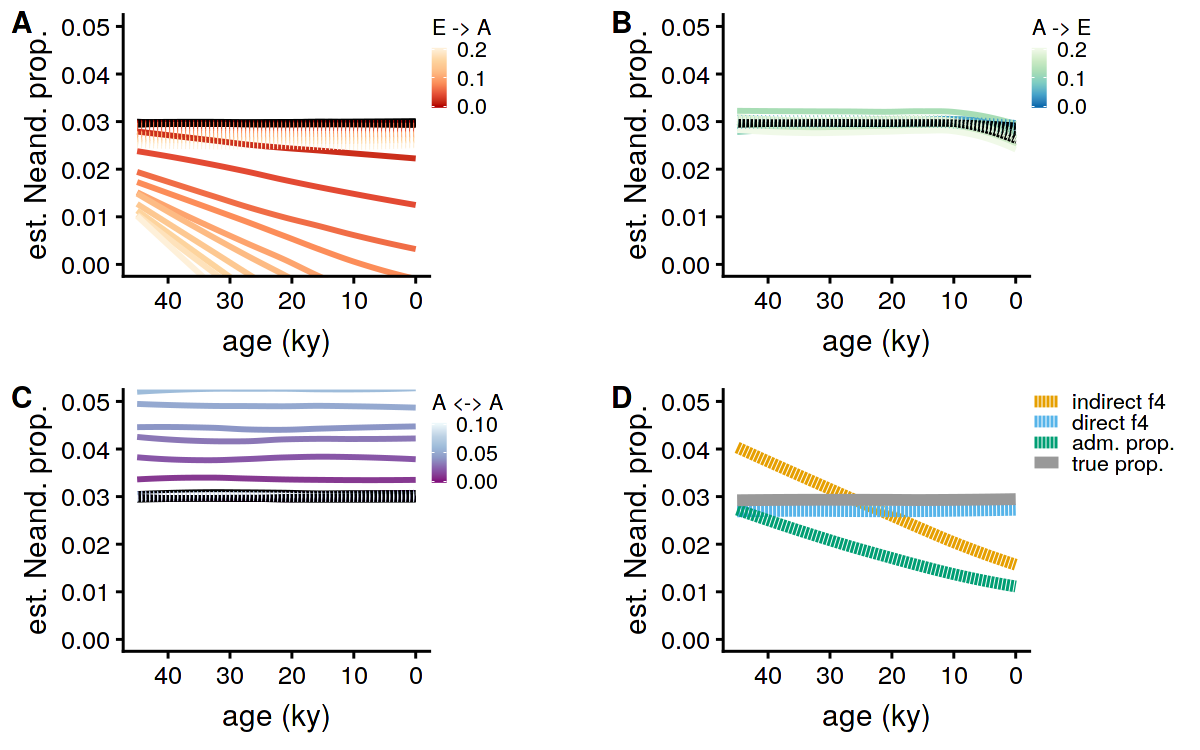

In [37]:
set_dim(8, 5)

p.full <- plot_grid(p1 + p1.psd4.lines.true + p1.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.box.margin = margin(b=80, l=-20)) + guides(color = guide_colorbar(barwidth = 0.5, barheight = 2)),
                    p2 + p2.psd4.lines.true + p2.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.box.margin = margin(b=80, l=-20)) + guides(color = guide_colorbar(barwidth = 0.5, barheight = 2)),
                    p3 + p3.psd4.lines.true + p3.psd4.lines + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.box.margin = margin(b=80, l=-20)) + guides(color = guide_colorbar(barwidth = 0.5, barheight = 2)),
                    p.top +                                   coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.box.margin = margin(b=100, l=-20), legend.key.height = unit(0,'lines')),
                    # p.top +                                   coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.') + theme(axis.text.x = element_text(size=12), legend.text = element_text(size=10), legend.title = element_text(size=10), legend.justification=c(.2,.7), legend.position=c(1,1), legend.key.height = unit(0,'lines')),
                    align = 'vh', axis='tblr',
                    ncol = 2,
                    labels = 'AUTO')
p.full
#save_plot('~/Google Drive/martin_neand_depletion_over_time/figs_rev_02f03b.pdf',
#          p.full, base_width = 8, base_height = 5)

category,N
mig_time,1750
ne_eur,1250
ne_afr,1250


`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


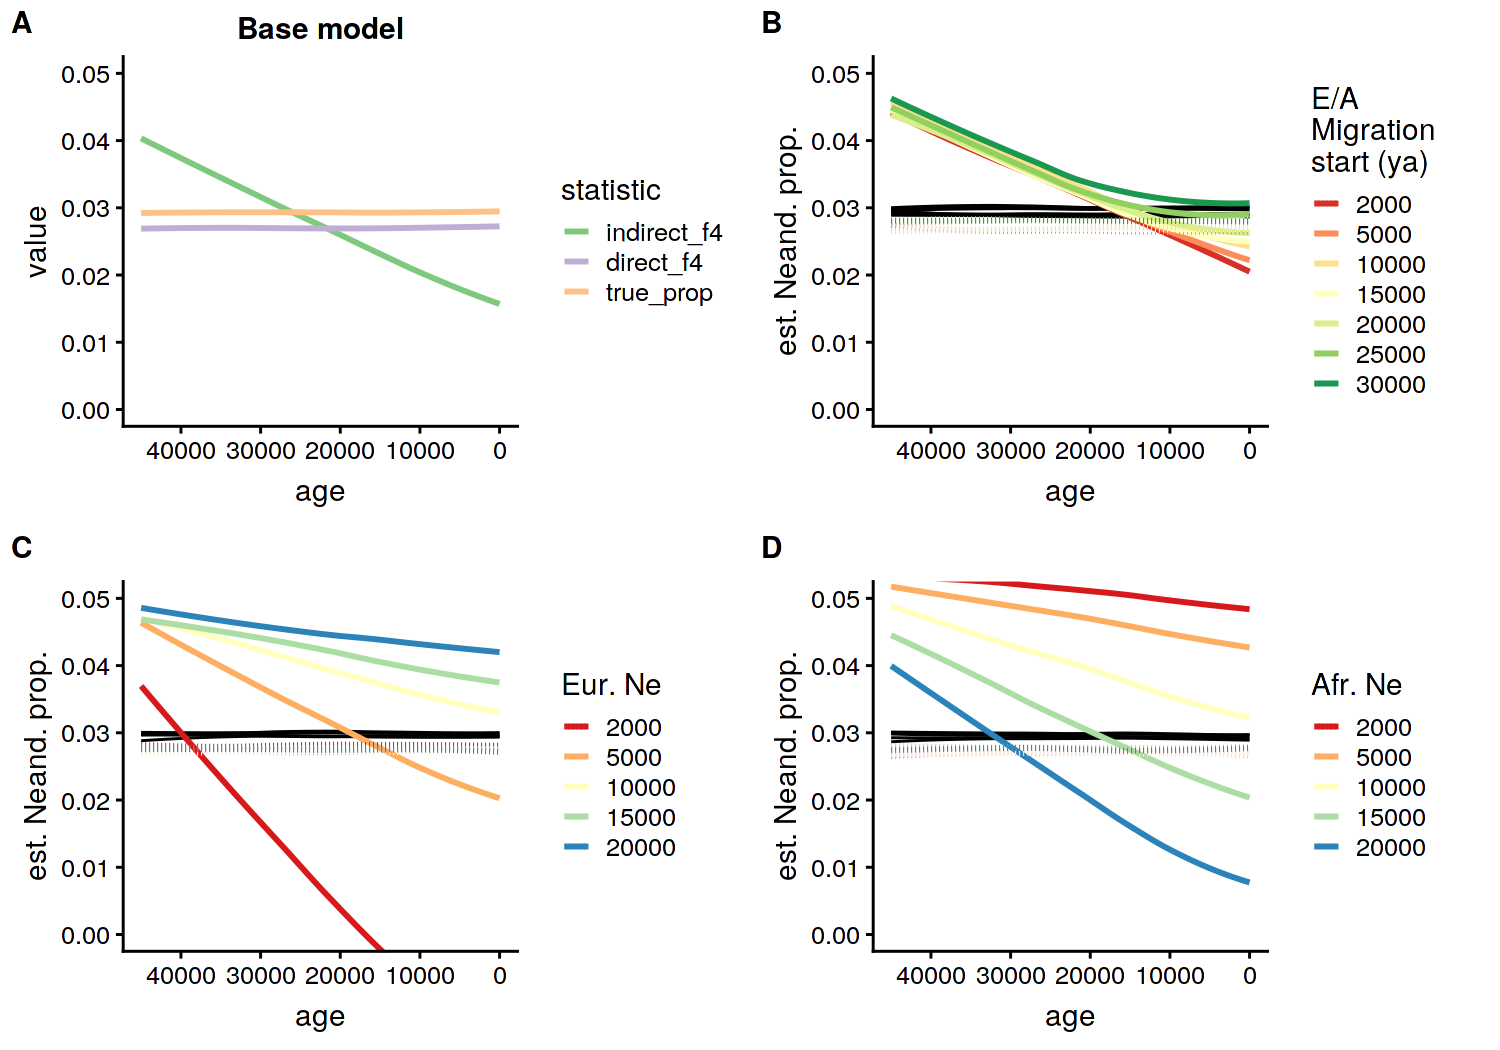

In [39]:
set_dim(10, 7)

#####
## code for supplemental figure showing effects of Ne and time of migration

# read_base_model('~/Documents/demographics_eur_afr/revisions_modify_one_param_at_time.n.5/')
# simsdir='~/Documents/demographics_eur_afr/revisions_modify_one_param_at_time.n.5/'
# dt.sims.full.grid.avg.top_mod.perterbations <- read_sims(simsdir)
# saveRDS(dt.sims.full.grid.avg.top_mod.perterbations, '~/Dropbox/martins_slow_decline/PNAS/Revised_Manuscript/revision_figures/dt.sims.full.grid.avg.top_mod.perterbations.rds')
dt.sims.full.grid.avg.top_mod.perterbations <- as.data.table(readRDS(here("data/rds/dt.sims.full.grid.avg.top_mod.perterbations.rds")))

dt.sims.full.grid.avg.top_mod.perterbations[, .N, category]

top_mod.top <- ggplot(top.sim.melt[variable %in% c('direct_f4', 'indirect_f4', 'true_prop')], 
                      aes(x=age, y=value, color=variable)) +
  geom_smooth(se=F) +
  scale_x_reverse() +
  scale_color_brewer('statistic', type = 'qual', palette = 1) +
  # scale_color_manual('statistic', values=cbPalette[c(2,3,4,1)]) +
  # scale_linetype_manual('statistic', values=c(2,2,2,1)) +
  ggtitle('Base model') +
  NULL
#top_mod.top

top_mod.p1 <- ggplot(mapping=aes(x=age, color=factor(mig_time), group=mig_time)) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'mig_time'], 
              aes(y=true_prop), lty=1, se=F, color='black', size=.5) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'mig_time'], 
              aes(y=indirect_f4), lty=1, se=F) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'mig_time'], 
              aes(y=direct_f4), lty=3, se=F) +
  scale_color_brewer('E/A\nMigration\nstart (ya)', type = 'div', palette = 'RdYlGn') +
  scale_x_reverse() +
  NULL

top_mod.p2 <- ggplot(mapping=aes(x=age, color=factor(ne_eur), group=ne_eur)) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'ne_eur'], 
              aes(y=true_prop), lty=1, se=F, color='black', size=.5) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'ne_eur'], 
              aes(y=indirect_f4), lty=1, se=F) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'ne_eur'], 
              aes(y=direct_f4), lty=3, se=F) +
  scale_color_brewer('Eur. Ne', type = 'div', palette = 'Spectral') +
  scale_x_reverse() +
  NULL

top_mod.p3 <- ggplot(mapping=aes(x=age, color=factor(ne_afr), group=ne_afr)) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'ne_afr'], 
              aes(y=true_prop), lty=1, se=F, color='black', size=.5) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'ne_afr'], 
              aes(y=indirect_f4), lty=1, se=F) +
  geom_smooth(data=dt.sims.full.grid.avg.top_mod.perterbations[category == 'ne_afr'], 
              aes(y=direct_f4), lty=3, se=F) +
  scale_color_brewer('Afr. Ne', type = 'div', palette = 'Spectral') +
  scale_x_reverse() +
  NULL

top_mod.p.full <- plot_grid(top_mod.top + coord_cartesian(ylim=c(0,.05)),
                            top_mod.p1 + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                            top_mod.p2 + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                            top_mod.p3 + coord_cartesian(ylim=c(0,.05)) + ylab('est. Neand. prop.'),
                            align = 'vh', axis='tblr',
                            ncol = 2,
                            labels = 'AUTO')
top_mod.p.full
#save_plot('~/Google Drive/martin_neand_depletion_over_time/figs_rev_SX_top_model_vs_Ne_time.2.pdf',
#          top_mod.p.full, base_width = 10, base_height = 7)

In [40]:
#########################################
##### overlap of various element types
#########################################

dt.elems <- fread('~/Documents/martin_neand_decline/bp_overlap_elems_range.txt')
setnames(dt.elems, c('bp', 'nreg', 'window_size', 'elem', 'elem_ovlp'))
dt.elems[, bp.frac := bp / max(bp), .(window_size,elem)]

ggplot(dt.elems, aes(y=elem, x=elem_ovlp, fill=bp.frac)) +
  geom_tile() + facet_wrap(~window_size)


dt.regions = data.table(fread('~/Documents/martin_neand_decline/slim_coords/protein_coding_regions.bed.1d', 
                              select = 6, col.names = 'len'),
                        cat='cds')
dt.regions = fread('cat ~/Documents/martin_neand_decline/slim_coords/*_regions.bed.1d.marked', 
                              col.names = c('chrom', 'start', 'end', 'cat'))
dt.regions[, .N, cat]
dt.regions[, len := end-start]
dt.regions[, median(len), cat]
dt.regions[, mean(len), cat]

ERROR: Error in fread("~/Documents/martin_neand_decline/bp_overlap_elems_range.txt"): File '~/Documents/martin_neand_decline/bp_overlap_elems_range.txt' does not exist or is non-readable. getwd()=='/mnt/expressions/mp/nea-over-time/notebooks'
